# Demo of graph optimisation on real graph to segment structures:

# TODO: implement edge classification predictions just as in the dummy graph:

In [1]:
import os

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np


In [2]:
import torch
import torch_geometric

from scipy.special import softmax


In [3]:
from grace.base import GraphAttrs, Annotation

from grace.simulate import random_graph, random_graph_mixed_motifs
from grace.models.datasets import dataset_from_graph
from grace.models.optimise import optimise_graph

from grace.io.image_dataset import ImageGraphDataset
from grace.models.feature_extractor import FeatureExtractor


### Load an example image + build graph:

In [4]:
IMAGE_DIR = "/Users/kulicna/Desktop/classifier/data/"
IMAGE_DIR, os.path.isdir(IMAGE_DIR)

('/Users/kulicna/Desktop/classifier/data/', True)

In [5]:
# class Compose(object):
#     def __init__(self, transforms):
#         self.transforms = transforms

#     def __call__(self, image, target):
#         for t in self.transforms:
#             image, target = t(image, target)
#         return image, target
    
def normalize8(I):
    I = np.array(I)
    mn = I.min()
    mx = I.max()

    mx -= mn

    I = ((I - mn)/mx) * 255
    return I.astype(np.uint8)


In [6]:
image_graph_dataset = ImageGraphDataset(
    image_dir=IMAGE_DIR,
    grace_dir=IMAGE_DIR,
    transform=lambda x,y: (x,y),
    image_filetype="mrc",
)

In [7]:
image_graph_dataset

In [8]:
for image, graph_data in image_graph_dataset:
    print (image.shape, graph_data.keys(), graph_data)

torch.Size([3710, 3838]) dict_keys(['graph', 'metadata']) {'graph': <networkx.classes.graph.Graph object at 0x1cb075fd0>, 'metadata': {'image_filename': 'FoilHole_24680421_Data_24671727_24671728_20181024_2216-78563_noDW'}}


In [9]:
image.dtype, image.max(), image.min()

(torch.float32, tensor(50.), tensor(2.))

In [10]:
# image_normalised = image.numpy()
# image_normalised = normalize8(image_normalised)
# image_normalised.shape, image_normalised.dtype, image_normalised.min(), image_normalised.max()

In [11]:
graph = graph_data['graph']
graph.number_of_nodes(), graph.number_of_edges()


(198, 575)

In [12]:
single_node = graph.nodes()[0]
single_node

{<GraphAttrs.NODE_X: 'x'>: 1193.3724365234375,
 <GraphAttrs.NODE_Y: 'y'>: 3504.8525390625,
 <GraphAttrs.NODE_CONFIDENCE: 'confidence'>: nan,
 <GraphAttrs.NODE_GROUND_TRUTH: 'node_ground_truth'>: <Annotation.UNKNOWN: 2>,
 <GraphAttrs.NODE_FEATURES: 'features'>: None}

In [13]:
pos = {idx: [node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]] for idx, node in graph.nodes(data=True)}
len(pos)

198

In [14]:
coords_x, coords_y = np.transpose(list(pos.values()))
coords_x.shape, coords_y.shape

((198,), (198,))

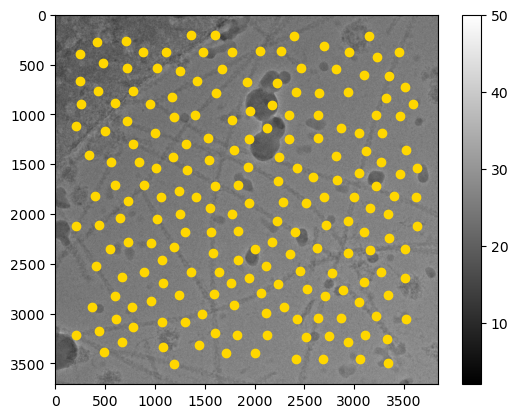

In [15]:
plt.imshow(image, cmap="binary_r")
plt.colorbar()
plt.scatter(coords_x, coords_y, color='gold')
plt.show()

### Now extract the features from each node patch:

In [16]:
extractor_model = torch.load("/Users/kulicna/Desktop/classifier/extractor/resnet152.pt")
extractor_model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [33]:
feature_extractor = FeatureExtractor(model=extractor_model)
feature_extractor

FeatureExtractor(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv

In [34]:
image, graph = feature_extractor(image=image, graph=graph_data)
type(image), type(graph)

(torch.Tensor, dict)

In [35]:
# # The image is unchanged, but the features are added to the graph_data:
# plt.imshow(image, cmap='binary_r')
# plt.title(image.shape)
# plt.show()

### Each node now has the feature vector appended to it:

In [36]:
graph = graph['graph']
single_node = graph.nodes()[0]
single_node, single_node[GraphAttrs.NODE_FEATURES].shape

({<GraphAttrs.NODE_X: 'x'>: 1193.3724365234375,
  <GraphAttrs.NODE_Y: 'y'>: 3504.8525390625,
  <GraphAttrs.NODE_CONFIDENCE: 'confidence'>: nan,
  <GraphAttrs.NODE_GROUND_TRUTH: 'node_ground_truth'>: <Annotation.UNKNOWN: 2>,
  <GraphAttrs.NODE_FEATURES: 'features'>: tensor([0.7357, 0.5131, 0.7362,  ..., 0.3728, 0.3937, 0.4191]),
  <GraphAttrs.NODE_PREDICTION: 'node_prediction'>: 1},
 torch.Size([2048]))

## Now run inference:

### Load the pre-trained models for node & edge classification:

In [37]:
classifier_model = torch.load("/Users/kulicna/Desktop/classifier/runs/2023-06-13_16-42-48/classifier.pt")
classifier_model

GCN(
  (conv1): GCNConv(2048, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 32)
  (node_classifier): Linear(in_features=32, out_features=2, bias=True)
  (edge_classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [75]:
def get_node_predictions(G, model):
    model.eval()
    anno = G.nodes.data()
    print (anno)

    predictions = []
    dataset = dataset_from_graph(G, n_hop=1, is_constrained=False)
    print (G.number_of_nodes(), G.number_of_edges())
    print (len(dataset))

    for data in dataset:  # Iterate in batches over the training/test dataset.
        # print (data.x.shape, data.edge_index, data.edge_index.shape)
        out = model(data.x, data.edge_index)
        # print ('outs', out[0].shape, out[1].shape)
        out = out[0]  # because it's only nodes at this point you care about! out[1] = edges
        # print (out)
        pred = out.argmax(dim=1)
        # print (pred)
        probs = softmax(out.detach().numpy())
        # print (probs)
        predictions.append((int(pred.numpy()), probs))

    # this is the prediction that the node is in the object
    for (_, node), prediction in zip(G.nodes.data(), predictions):
        # for a FP, we want this to be the prob that it's *NOT* in the object
        # print("pred", pred, pred[1].shape)
        
        node[GraphAttrs.NODE_PREDICTION] = np.clip(float(prediction[1][0, 0]), 0, 1)
        # node[GraphAttrs.NODE_PREDICTION] = np.clip(float(prediction[1][0, 1]), 0, 1)
        # node[GraphAttrs.NODE_PREDICTION] = prediction[0]

    return G


In [76]:
graph = get_node_predictions(graph, classifier_model)
graph


[(0, {<GraphAttrs.NODE_X: 'x'>: 1193.3724365234375, <GraphAttrs.NODE_Y: 'y'>: 3504.8525390625, <GraphAttrs.NODE_CONFIDENCE: 'confidence'>: nan, <GraphAttrs.NODE_GROUND_TRUTH: 'node_ground_truth'>: <Annotation.UNKNOWN: 2>, <GraphAttrs.NODE_FEATURES: 'features'>: tensor([0.7357, 0.5131, 0.7362,  ..., 0.3728, 0.3937, 0.4191]), <GraphAttrs.NODE_PREDICTION: 'node_prediction'>: 1.0}), (1, {<GraphAttrs.NODE_X: 'x'>: 3338.7197265625, <GraphAttrs.NODE_Y: 'y'>: 3498.38720703125, <GraphAttrs.NODE_CONFIDENCE: 'confidence'>: nan, <GraphAttrs.NODE_GROUND_TRUTH: 'node_ground_truth'>: <Annotation.UNKNOWN: 2>, <GraphAttrs.NODE_FEATURES: 'features'>: tensor([0.7807, 0.4811, 0.8263,  ..., 0.4247, 0.3669, 0.4425]), <GraphAttrs.NODE_PREDICTION: 'node_prediction'>: 1.0}), (2, {<GraphAttrs.NODE_X: 'x'>: 2417.74267578125, <GraphAttrs.NODE_Y: 'y'>: 3454.126953125, <GraphAttrs.NODE_CONFIDENCE: 'confidence'>: nan, <GraphAttrs.NODE_GROUND_TRUTH: 'node_ground_truth'>: <Annotation.UNKNOWN: 2>, <GraphAttrs.NODE_FEAT

In [77]:
def dataset_from_whole_graph(
    graph: nx.Graph, *, n_hop: int = 1, is_constrained: bool = True,
) -> list[torch_geometric.data.Data]:
    """Create a pytorch geometric dataset from a give networkx graph.

    Parameters
    ----------
    graph : graph
        A networkx graph.
    n_hop : int
        The number of hops from the central node when creating the subgraphs.

    Returns
    -------
    dataset : list
        A list of pytorch geometric data objects representing the extracted
        subgraphs.
    """

    # dataset = []

    sub_graph = graph
    edge_label = [
        edge[GraphAttrs.EDGE_GROUND_TRUTH]
        for _, _, edge in sub_graph.edges(data=True)
    ]

    x = np.stack(
        [
            node[GraphAttrs.NODE_FEATURES]
            for _, node in sub_graph.nodes(data=True)
        ],
        axis=0,
    )

    pos = np.stack(
        [
            (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y])
            for _, node in sub_graph.nodes(data=True)
        ],
        axis=0,
    )

    # TODO: edge attributes
    # central_node = np.array(
    #     [values[GraphAttrs.NODE_X], values[GraphAttrs.NODE_Y]]
    # )
    # edge_attr = pos - central_node

    item = nx.convert_node_labels_to_integers(sub_graph)
    edges = list(item.edges)
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    data = torch_geometric.data.Data(
        x=torch.Tensor(x),
        edge_index=edge_index,
        # edge_attr=torch.Tensor(edge_attr),
        edge_label=torch.Tensor(edge_label).long(),
        pos=torch.Tensor(pos),
        # y=torch.as_tensor([values[GraphAttrs.NODE_GROUND_TRUTH]]),
    )

    # dataset.append(data)

    # return dataset

    return data


In [78]:
def get_edge_predictions(G, model):
    model.eval()
    
    predictions = []
    dataset_single_batch = dataset_from_whole_graph(G, n_hop=1, is_constrained=False)
    print (G.number_of_nodes(), G.number_of_edges())
    print (len(dataset_single_batch))
    print (dataset_single_batch)

    data = dataset_single_batch
    print (data.x.shape, data.edge_index, data.edge_index.shape)
    out = model(data.x, data.edge_index)
    print ('outs', out[0].shape, out[1].shape)
    out = out[1]  # because it's only edges at this point you care about! out[1] = edges
    print ("out[1]", out.shape)
    pred = out.argmax(dim=1)
    print ("pred", pred.shape)
    probs = softmax(out.detach().numpy())
    print ("probs", probs.shape)
    # predictions.append((int(pred.numpy()), probs))
    
    predictions = {}
    for e in range(data.edge_index.shape[-1]):
        src_node_idx = data.edge_index[0][e].int().numpy()
        tgt_node_idx = data.edge_index[1][e].int().numpy()
        predictions[f"{src_node_idx}-{tgt_node_idx}"] = np.clip(float(probs[e, 0]), 0, 1)
        # predictions[f"{src_node_idx}-{tgt_node_idx}"] = np.clip(float(probs[e, 1]), 0, 1)
        # predictions[f"{src_node_idx}-{tgt_node_idx}"] = pred[e].detach().numpy()
        
    print ("predictions", predictions)
    # predictions = (pred.int().numpy(), probs)
    # print ("predictions", predictions[0].shape, predictions[1].shape)

    print ("HERE!")

    print (data.x.shape, data.edge_index, data.edge_index.shape)
    print (G.edges.data())

    for src, tgt, edge in G.edges.data():
        # src, tgt, attribs = edge
        print (predictions[f"{src}-{tgt}"])
        edge[GraphAttrs.EDGE_PREDICTION] = predictions[f"{src}-{tgt}"]
        
        
    # # this is the prediction that the node is in the object
    # for (something, edge), prediction in zip(G.edges.data(), predictions):
    #     print (something, edge)
    #     # for a FP, we want this to be the prob that it's *NOT* in the object
    #     # print("pred", pred, pred[1].shape)
    #     edge[GraphAttrs.EDGE_PREDICTION] = np.clip(float(prediction[1][0, 0]), 0, 1)

    return G


In [79]:
graph = get_edge_predictions(graph, classifier_model)
graph


198 575
4
Data(x=[198, 2048], edge_index=[2, 575], pos=[198, 2], edge_label=[575])
torch.Size([198, 2048]) tensor([[  0,   0,   0,  ..., 194, 195, 196],
        [  5,   7,   9,  ..., 195, 196, 197]]) torch.Size([2, 575])
outs torch.Size([1, 2]) torch.Size([575, 2])
out[1] torch.Size([575, 2])
pred torch.Size([575])
probs (575, 2)
predictions {'0-5': 0.0018575565190985799, '0-7': 0.0019834251143038273, '0-9': 0.0019940135534852743, '0-2': 0.0019271753262728453, '0-6': 0.0018581292824819684, '0-8': 0.0018568267114460468, '0-1': 0.0018578661838546395, '0-10': 0.0019934140145778656, '1-29': 0.001241595484316349, '1-3': 0.001250843983143568, '1-12': 0.0012295367196202278, '1-2': 0.0012747773434966803, '1-4': 0.0012344388524070382, '2-17': 0.0009338678210042417, '2-3': 0.0009375042282044888, '2-7': 0.000983329606242478, '2-16': 0.0009434493840672076, '3-17': 0.0011060473043471575, '3-18': 0.0010814585257321596, '3-11': 0.0010686952155083418, '3-4': 0.0010957919294014573, '4-11': 0.0011953845

In [80]:
graph.edges.data()

EdgeDataView([(0, 5, {<GraphAttrs.EDGE_GROUND_TRUTH: 'edge_ground_truth'>: <Annotation.UNKNOWN: 2>, <GraphAttrs.EDGE_PREDICTION: 'edge_prediction'>: 0.0018575565190985799}), (0, 7, {<GraphAttrs.EDGE_GROUND_TRUTH: 'edge_ground_truth'>: <Annotation.UNKNOWN: 2>, <GraphAttrs.EDGE_PREDICTION: 'edge_prediction'>: 0.0019834251143038273}), (0, 9, {<GraphAttrs.EDGE_GROUND_TRUTH: 'edge_ground_truth'>: <Annotation.UNKNOWN: 2>, <GraphAttrs.EDGE_PREDICTION: 'edge_prediction'>: 0.0019940135534852743}), (0, 2, {<GraphAttrs.EDGE_GROUND_TRUTH: 'edge_ground_truth'>: <Annotation.UNKNOWN: 2>, <GraphAttrs.EDGE_PREDICTION: 'edge_prediction'>: 0.0019271753262728453}), (0, 6, {<GraphAttrs.EDGE_GROUND_TRUTH: 'edge_ground_truth'>: <Annotation.UNKNOWN: 2>, <GraphAttrs.EDGE_PREDICTION: 'edge_prediction'>: 0.0018581292824819684}), (0, 8, {<GraphAttrs.EDGE_GROUND_TRUTH: 'edge_ground_truth'>: <Annotation.UNKNOWN: 2>, <GraphAttrs.EDGE_PREDICTION: 'edge_prediction'>: 0.0018568267114460468}), (0, 1, {<GraphAttrs.EDGE_G

### Plot the predictions of the model:

In [81]:
confidence_nodes = [single_node[1][GraphAttrs.NODE_PREDICTION] for single_node in graph.nodes.data()]
confidence_edges = [single_edge[2][GraphAttrs.EDGE_PREDICTION] for single_edge in graph.edges.data()]
len(confidence_nodes), len(confidence_edges)

(198, 575)

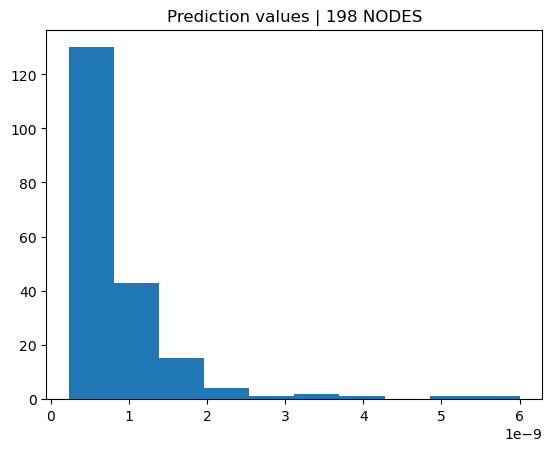

In [82]:
plt.hist(confidence_nodes)
plt.title(f"Prediction values | {len(confidence_nodes)} NODES")
plt.show()

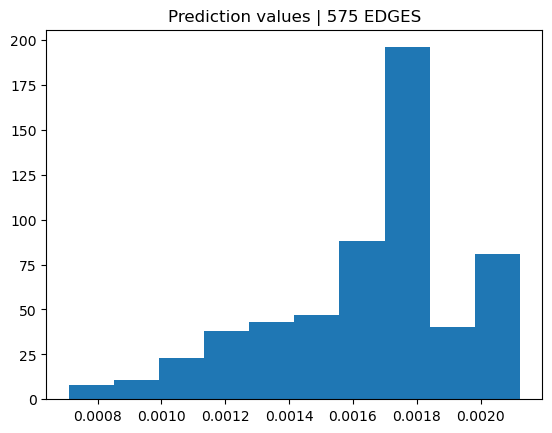

In [83]:
plt.hist(confidence_edges)
plt.title(f"Prediction values | {len(confidence_edges)} EDGES")
plt.show()

# Optimise a real graph:

In [84]:
x = optimise_graph(graph)

### Visualise the graph & individual objects:

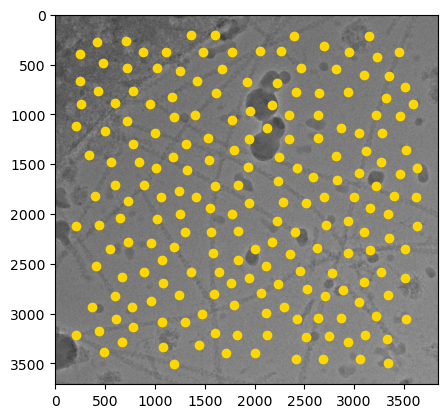

In [85]:
plt.imshow(image, cmap="binary_r")
plt.scatter(coords_x, coords_y, color='gold')
plt.show()

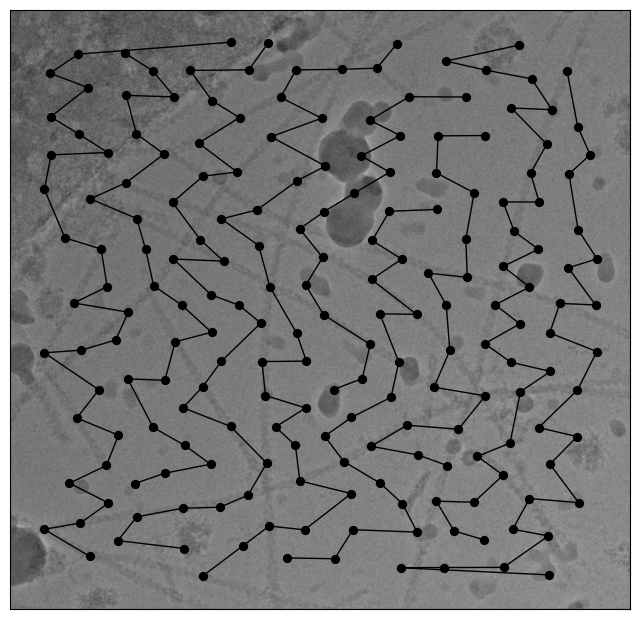

In [86]:
pos = {idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) for idx, node in x.nodes(data=True)}
fig, ax = plt.subplots(figsize=(8, 8))

# draw all nodes/vertices in the graph, including those not determined to be part of the objects
plt.imshow(image, cmap="binary_r")
nx.draw_networkx(x, ax=ax, pos=pos, with_labels=False, node_color="k", node_size=32)
plt.show()


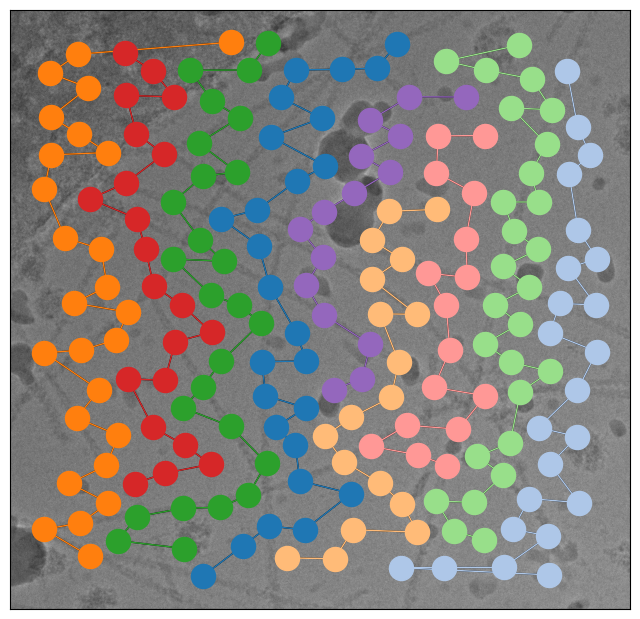

In [87]:

# plt.ion()

pos = {idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) for idx, node in x.nodes(data=True)}
fig, ax = plt.subplots(figsize=(8, 8))

# draw all nodes/vertices in the graph, including those not determined to be 
# part of the objects
nx.draw_networkx(x, ax=ax, pos=pos, with_labels=False, node_color="k", node_size=32)

# get each connected subgraph and draw it with a different colour
cc = nx.connected_components(x)
for index, sg in enumerate(cc):
    # print (index, sg)

    if len(sg) <= 1:
        continue

    c_idx = np.array(plt.cm.tab20((index % 20) / 20)).reshape(1, -1)
    sg = x.subgraph(sg).copy()
    plt.imshow(image, cmap="binary_r")
    nx.draw_networkx(sg, pos=pos, edge_color=c_idx, node_color=c_idx, with_labels=False)

plt.show()

### Done!